## Project 8 - Data Science Life Cycle

### Project Objectives

- Feature engineering
- Using sklearn to build simple and more complex linear models
- Building a data pipeline using pandas
- Identifying informative variables through EDA
- Feature engineering with categorical variables
- Classification using logistic regression
- Classification metrics

## Setup Notebook

In [352]:
!pip install geopandas

In [353]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview

In this project, you will use all the tools and knowledge that you've learned in class to explore and model New York Taxi data. You will create a regression model that predicts the travel time of a taxi ride and you will also create a binary classifier to predict whether or not someone will tip at the end of their ride. 

# The Data

Features of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full dataset is over 1 GB, so we've placed a simple random sample of the data into `taxi.csv`.

Columns of the `taxi.csv` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance in miles
- `payment_method`: 1=Credit card, 2=Cash, 3=No charge, 4=Dispute
- `surcharge`: Improvement surcharge
- `tax`: State and municipal taxes
- `fare`: the time-and-distance fare calculated by the meter
- `tip`: the amount of credit card tips, cash tips are not included

# 1. Data Selection and Cleaning

In this part, you will limit the data to trips that began and ended on Manhattan Island ([map](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488)). 

## Question 1a
Import `taxi.csv` as a DataFrame and assign it to a variable called `all_taxi`. 

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

In [354]:
# Import the csv into a geopandas dataframe
all_taxi = gpd.read_file('taxi.csv')

# Change string data-types into float so can apply filters to columns
all_taxi = all_taxi.astype({'pickup_lat':'float',
                'pickup_lon':'float',
                'dropoff_lat':'float',
                'dropoff_lon':'float',
                'distance':'float',
                'passengers':'float'
                })

# Apply filters to pickup_lat, pickup_lon, dropoff_lat, and dropoff_lon columns
all_taxi = all_taxi[(all_taxi['pickup_lat']>= 40.6) 
                     & (all_taxi['pickup_lat']<= 40.88) 
                     & (all_taxi['pickup_lon'] >= -74.03) 
                     & (all_taxi['pickup_lon']<= -73.75)
                     & (all_taxi['dropoff_lat']>= 40.6) 
                     & (all_taxi['dropoff_lat']<= 40.88) 
                     & (all_taxi['dropoff_lon'] >= -74.03) 
                     & (all_taxi['dropoff_lon']<= -73.75)
]

# View DataFrame
all_taxi.head()

pickup_datetime     dropoff_datetime  passengers  distance  pickup_lat  \
0  2016-01-22 23:58:43  2016-01-23 00:00:20         2.0      0.20   40.741268   
1  2016-01-03 10:04:26  2016-01-03 10:12:25         1.0      2.02   40.780983   
2  2016-01-04 18:38:53  2016-01-04 18:45:42         3.0      1.30   40.711304   
3  2016-01-14 10:16:54  2016-01-14 10:27:13         1.0      2.00   40.707825   
4  2016-01-31 16:30:50  2016-01-31 16:33:21         1.0      0.60   40.760883   

   pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  tax  fare  \
0  -74.001480    40.743977   -73.999565              2       0.3  0.5   3.0   
1  -73.956734    40.758957   -73.976898              2       0.3  0.5   8.5   
2  -74.008713    40.727184   -74.005150              2       0.3  0.5   7.0   
3  -74.001762    40.715496   -74.015656              1       0.3  0.5  10.0   
4  -73.960930    40.767666   -73.959328              1       0.3  0.5   4.0   

   tip  
0  0.0  
1  0.0  
2  0.0  
3  3.2  
4  1.2

## Question 1b
Create a plot of pickup locations using Folium and the `HeatMap` function. The `HeatMap` will show the density of pickup locations in different areas of the city, where red areas have relatively more pickups. As you can see, most of the pickups are in Manhattan in addition to two hot spots corresponding to airports. Your plot should look like this (radius = 10).
<br>
<img src="images/q1b.png" alt="drawing" width="500"/>
<br> 

In [358]:
!pip install folium

In [359]:
import folium
from folium import Circle
from folium.plugins import HeatMap

In [394]:
# Create a map of New York
map_1 = folium.Map(location=[40.7484, -73.9857], 
                   tiles='cartodbpositron', 
                   zoom_start=10)

# Create the geometry column from pickup_lon and pick_lat 
all_taxi = gpd.GeoDataFrame(all_taxi, geometry=gpd.points_from_xy(all_taxi.pickup_lon, all_taxi.pickup_lat))
all_taxi.crs = {'init': 'epsg:4326'}

# Plot the x and y points from geometry to make a heat map
HeatMap(data=list(zip(all_taxi.to_crs(epsg=4326).geometry.y,
                      all_taxi.to_crs(epsg=4326).geometry.x)),
        radius=10).add_to(map_1)

# Display map
map_1

## Question 1c
We'll be trying to estimate the duration of a taxi ride and therefore, we will need to compute the duration of each ride. Create a new column in `all_taxi` called `'duration'` and assign to it the length of the taxi ride in seconds. The datatype for `'duration'` should be `int`. 

In [370]:
# Convert to datetime and localize to EST
all_taxi['pickup_datetime'] = pd.to_datetime(all_taxi['pickup_datetime'], errors='coerce')
all_taxi['dropoff_datetime'] = pd.to_datetime(all_taxi['dropoff_datetime'], errors='coerce')
all_taxi['pickup_datetime'] = all_taxi['pickup_datetime'].dt.tz_localize(tz='EST')
all_taxi['dropoff_datetime'] = all_taxi['dropoff_datetime'].dt.tz_localize(tz='EST')

# Write your code here
all_taxi['duration'] = (all_taxi['dropoff_datetime'] - all_taxi['pickup_datetime']).dt.total_seconds().astype(int)


# View DataFrame
all_taxi.head()

pickup_datetime          dropoff_datetime  passengers  distance  \
0 2016-01-22 23:58:43-05:00 2016-01-23 00:00:20-05:00         2.0      0.20   
1 2016-01-03 10:04:26-05:00 2016-01-03 10:12:25-05:00         1.0      2.02   
2 2016-01-04 18:38:53-05:00 2016-01-04 18:45:42-05:00         3.0      1.30   
3 2016-01-14 10:16:54-05:00 2016-01-14 10:27:13-05:00         1.0      2.00   
4 2016-01-31 16:30:50-05:00 2016-01-31 16:33:21-05:00         1.0      0.60   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  \
0   40.741268  -74.001480    40.743977   -73.999565              2       0.3   
1   40.780983  -73.956734    40.758957   -73.976898              2       0.3   
2   40.711304  -74.008713    40.727184   -74.005150              2       0.3   
3   40.707825  -74.001762    40.715496   -74.015656              1       0.3   
4   40.760883  -73.960930    40.767666   -73.959328              1       0.3   

   tax  fare  tip                    geometry     pickup datetime  duration  
0  0.5   3.0  0.0  POINT (-74.00148 40.74127) 2016-01-22 23:58:43        97  
1  0.5   8.5  0.0  POINT (-73.95673 40.78098) 2016-01-03 10:04:26       479  
2  0.5   7.0  0.0   POINT (-74.00871 40.7113) 2016-01-04 18:38:53       409  
3  0.5  10.0  3.2  POINT (-74.00176 40.70782) 2016-01-14 10:16:54       619  
4  0.5   4.0  1.2  POINT (-73.96093 40.76088) 2016-01-31 16:30:50       151

## Question 1d
Create a DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. Inequalities should not be strict (e.g., `<=` instead of `<`) unless comparing to 0. You will need to first create a new column in `all_taxi` called `'speed'` and assign to it the average speed in miles per hour.

In [348]:
# Calculate speed from distance and duration
all_taxi['speed'] = all_taxi['distance'].astype(float) / (all_taxi['duration'] / 3600)

# Apply filters to passengers, distance, duration, speed
clean_taxi = all_taxi[(all_taxi['passengers'] > 0)
                   & (all_taxi['distance'] > 0) 
                   & (all_taxi['duration'] >= 60) 
                   & (all_taxi['duration'] <= 3600) 
                   & (all_taxi['speed'] <= 100) ]
                   
                  
# View DataFrame

clean_taxi.head()

pickup_datetime          dropoff_datetime  passengers  distance  \
0 2016-01-22 23:58:43-05:00 2016-01-23 00:00:20-05:00         2.0      0.20   
1 2016-01-03 10:04:26-05:00 2016-01-03 10:12:25-05:00         1.0      2.02   
2 2016-01-04 18:38:53-05:00 2016-01-04 18:45:42-05:00         3.0      1.30   
3 2016-01-14 10:16:54-05:00 2016-01-14 10:27:13-05:00         1.0      2.00   
4 2016-01-31 16:30:50-05:00 2016-01-31 16:33:21-05:00         1.0      0.60   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  \
0   40.741268  -74.001480    40.743977   -73.999565              2       0.3   
1   40.780983  -73.956734    40.758957   -73.976898              2       0.3   
2   40.711304  -74.008713    40.727184   -74.005150              2       0.3   
3   40.707825  -74.001762    40.715496   -74.015656              1       0.3   
4   40.760883  -73.960930    40.767666   -73.959328              1       0.3   

   tax  fare  tip                    geometry  duration      speed  
0  0.5   3.0  0.0  POINT (-74.00148 40.74127)        97   7.422680  
1  0.5   8.5  0.0  POINT (-73.95673 40.78098)       479  15.181628  
2  0.5   7.0  0.0   POINT (-74.00871 40.7113)       409  11.442543  
3  0.5  10.0  3.2  POINT (-74.00176 40.70782)       619  11.631664  
4  0.5   4.0  1.2  POINT (-73.96093 40.76088)       151  14.304636

Next, we want to collect trips from `clean_taxi` that start and end within the boundaries of Manhattan Island.

We're in luck because `geodatasets` has a builtin dataset for the boundaries of New York Boroughs.

In [250]:
!pip install geodatasets

In [252]:
from geodatasets import get_path

path = get_path('nybb')
boroughs = gpd.read_file(path)
boroughs.set_index('BoroCode', inplace=True)
boroughs.sort_index(inplace=True)
boroughs.to_crs(epsg=4326, inplace=True)
boroughs.head()

BoroName     Shape_Leng    Shape_Area  \
BoroCode                                               
1             Manhattan  359299.096471  6.364715e+08   
2                 Bronx  464392.991824  1.186925e+09   
3              Brooklyn  741080.523166  1.937479e+09   
4                Queens  896344.047763  3.045213e+09   
5         Staten Island  330470.010332  1.623820e+09   

                                                   geometry  
BoroCode                                                     
1         MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
2         MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
3         MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
4         MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...  
5         MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...

Let's plot these quickly.

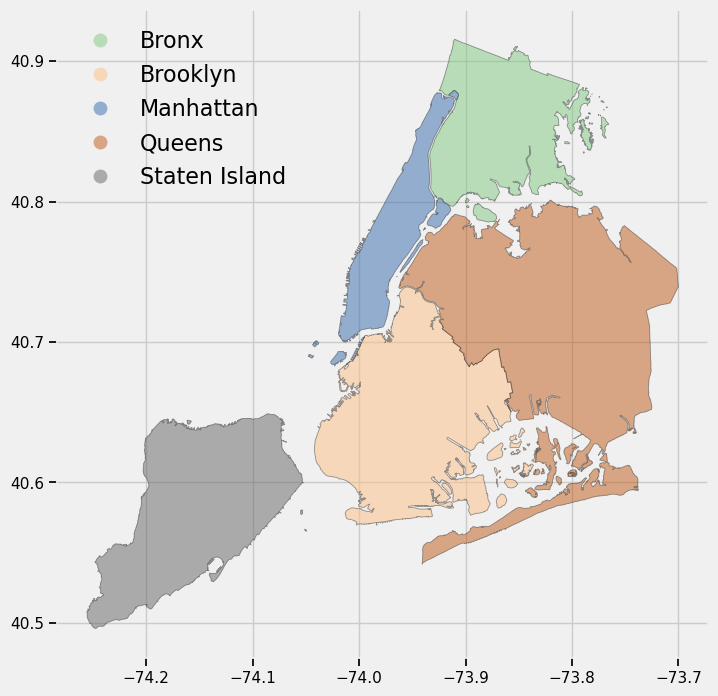

In [254]:
ax = boroughs.plot(figsize=(8, 8), column='BoroName', categorical=True, 
                   cmap='Accent', linewidth=.6, edgecolor='0.2', alpha=0.5,
                   legend=True, legend_kwds={'loc': 2,'fontsize':16, 
                                             'frameon':False})

Let's create a new DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within the boundaries of Manhattan Island.

In [256]:
!pip install shapely

In [258]:
from shapely.geometry import MultiPoint

First we have to create a `MultiPoint` geometry for each trip (pickup and dropoff).

In [260]:
clean_taxi['geometry'] = clean_taxi.apply(lambda row: MultiPoint([(row['pickup_lon'], row['pickup_lat']), 
                                                                  (row['dropoff_lon'], row['dropoff_lat'])]), axis=1)
clean_taxi = gpd.GeoDataFrame(clean_taxi)
clean_taxi.head()

pickup_datetime          dropoff_datetime  passengers  distance  \
0 2016-01-22 23:58:43-05:00 2016-01-23 00:00:20-05:00         2.0      0.20   
1 2016-01-03 10:04:26-05:00 2016-01-03 10:12:25-05:00         1.0      2.02   
2 2016-01-04 18:38:53-05:00 2016-01-04 18:45:42-05:00         3.0      1.30   
3 2016-01-14 10:16:54-05:00 2016-01-14 10:27:13-05:00         1.0      2.00   
4 2016-01-31 16:30:50-05:00 2016-01-31 16:33:21-05:00         1.0      0.60   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  \
0   40.741268  -74.001480    40.743977   -73.999565              2       0.3   
1   40.780983  -73.956734    40.758957   -73.976898              2       0.3   
2   40.711304  -74.008713    40.727184   -74.005150              2       0.3   
3   40.707825  -74.001762    40.715496   -74.015656              1       0.3   
4   40.760883  -73.960930    40.767666   -73.959328              1       0.3   

   tax  fare  tip                                           geometry  \
0  0.5   3.0  0.0  MULTIPOINT (-74.00148 40.74127, -73.99957 40.7...   
1  0.5   8.5  0.0  MULTIPOINT (-73.95673 40.78098, -73.9769 40.75...   
2  0.5   7.0  0.0  MULTIPOINT (-74.00871 40.7113, -74.00515 40.72...   
3  0.5  10.0  3.2  MULTIPOINT (-74.00176 40.70782, -74.01566 40.7...   
4  0.5   4.0  1.2  MULTIPOINT (-73.96093 40.76088, -73.95933 40.7...   

   duration      speed  
0      97.0   7.422680  
1     479.0  15.181628  
2     409.0  11.442543  
3     619.0  11.631664  
4     151.0  14.304636

Next, for each trip we need to check if it started and ended within Manhattan. Note that the dataset is large, and this can take a while to run depending on your machine (5-10 min).

In [262]:
manhattan_taxi = clean_taxi[clean_taxi.within(boroughs[boroughs['BoroName'] == 'Manhattan'].iloc[0].geometry)]

Let's see if our filtering worked.

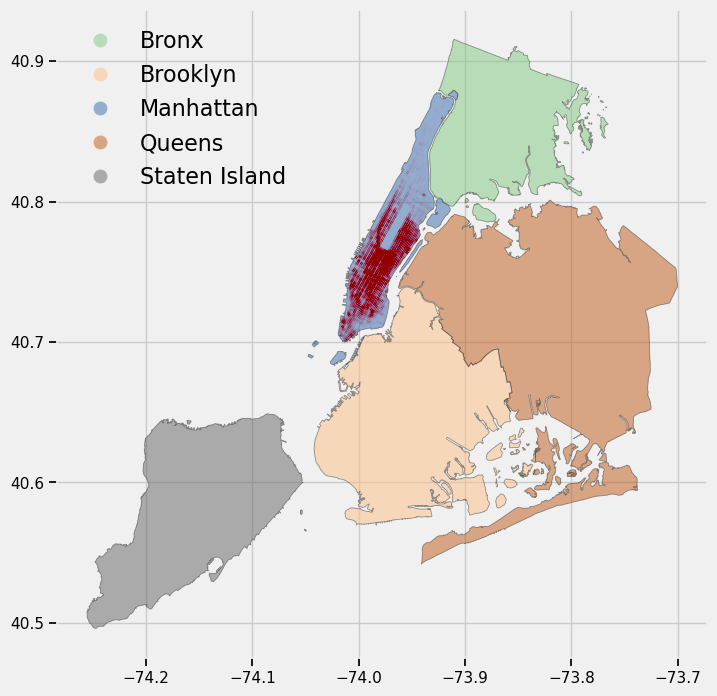

In [186]:
ax = boroughs.plot(figsize=(8, 8), column='BoroName', categorical=True, 
                   cmap='Accent', linewidth=.6, edgecolor='0.2', alpha=0.5,
                   legend=True, legend_kwds={'loc': 2,'fontsize':16, 
                                             'frameon':False})
manhattan_taxi.plot(ax=ax, markersize=0.00001, color='r');

It worked! That filtering operation takes quite a bit of time, so let's save a `.csv` and create a checkpoint.

In [264]:
manhattan_taxi.to_csv('manhattan_taxi.csv', index=False)

## Question 1e (ungraded)
In the following cell, print a summary of the data selection and cleaning you performed. For example, you should print something like: "Of the original 1000 trips, 21 anomolous trips (2.1%) were removed through data cleaning, and then the 600 trips within Manhattan were selected for further analysis." (Note that the numbers in this example are not accurate.)

In [266]:
original_trip_number = len(all_taxi)
anomolous_trips = len(all_taxi) - len(clean_taxi)
anomolous_percent = round(anomolous_trips / original_trip_number * 100, 2)
manhattan_count = str(len(manhattan_taxi))



print('Of the original ' + str(original_trip_number) + ' trips, ' + str(anomolous_trips)
      + " (" + str(anomolous_percent) + '%) were removed through data cleaning, then the ' 
      + manhattan_count + ' trips within Manhattan were selected for further analysis.')

Of the original 97667 trips, 1236 (1.27%) were removed through data cleaning, then the 82953 trips within Manhattan were selected for further analysis.


_Type your answer here, replacing this text._

# Predicting Trip Duration
In this section, you will develop a machine learning model to predict the duration of taxi trips in New York.

# 2. Exploratory Data Analysis
In this part, you'll choose which days to include as training data in your regression model. 

Your goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

## Question 2a
Add a new column named `'date'` to `manhattan_taxi` that contains the date (but not the time) of pickup.

In [268]:
# Extract the date using built-in dt.date 
manhattan_taxi['date'] = manhattan_taxi['pickup_datetime'].dt.date

# View DataFrame
manhattan_taxi.head()

pickup_datetime          dropoff_datetime  passengers  distance  \
0 2016-01-22 23:58:43-05:00 2016-01-23 00:00:20-05:00         2.0      0.20   
1 2016-01-03 10:04:26-05:00 2016-01-03 10:12:25-05:00         1.0      2.02   
2 2016-01-04 18:38:53-05:00 2016-01-04 18:45:42-05:00         3.0      1.30   
3 2016-01-14 10:16:54-05:00 2016-01-14 10:27:13-05:00         1.0      2.00   
4 2016-01-31 16:30:50-05:00 2016-01-31 16:33:21-05:00         1.0      0.60   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  \
0   40.741268  -74.001480    40.743977   -73.999565              2       0.3   
1   40.780983  -73.956734    40.758957   -73.976898              2       0.3   
2   40.711304  -74.008713    40.727184   -74.005150              2       0.3   
3   40.707825  -74.001762    40.715496   -74.015656              1       0.3   
4   40.760883  -73.960930    40.767666   -73.959328              1       0.3   

   tax  fare  tip                                           geometry  \
0  0.5   3.0  0.0  MULTIPOINT (-74.00148 40.74127, -73.99957 40.7...   
1  0.5   8.5  0.0  MULTIPOINT (-73.95673 40.78098, -73.9769 40.75...   
2  0.5   7.0  0.0  MULTIPOINT (-74.00871 40.7113, -74.00515 40.72...   
3  0.5  10.0  3.2  MULTIPOINT (-74.00176 40.70782, -74.01566 40.7...   
4  0.5   4.0  1.2  MULTIPOINT (-73.96093 40.76088, -73.95933 40.7...   

   duration      speed        date  
0      97.0   7.422680  2016-01-22  
1     479.0  15.181628  2016-01-03  
2     409.0  11.442543  2016-01-04  
3     619.0  11.631664  2016-01-14  
4     151.0  14.304636  2016-01-31

## Question 2b
Create a data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016. Make sure that the visualization type is appropriate for the visualized data.

Hint: How do you expect taxi usage to differ on blizzard days?

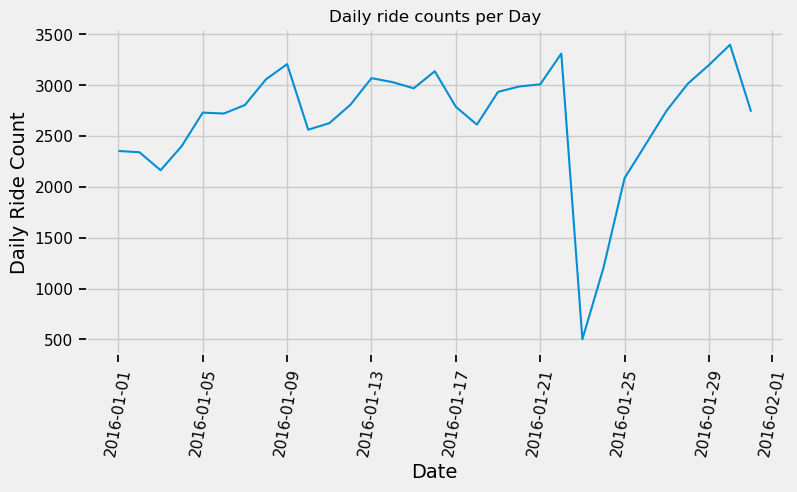

In [270]:
# The count of rides is aggregqted per day
manhattan_dailycount = manhattan_taxi.groupby('date').agg(count=('date', 'count'))
manhattan_dailycount.reset_index(inplace=True)

# A lineplot is used to plot the daily ride count over time
plt.figure(figsize=(8, 4))
sns.lineplot(x='date', y='count', data=manhattan_dailycount);

plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=80)
plt.ylabel('Daily Ride Count', fontsize=14)
plt.title('Daily ride counts per Day')


plt.show()

## Question 2c
We have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards.

In [272]:
import re
import calendar

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



In [274]:
atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [n for n in range(1, 32) if n not in atypical]
print(typical_dates)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 27, 28, 29, 30, 31]


Create a new DataFrame that only contains `typical_dates` and assign it to a new variable called `final_taxi`.

In [372]:
# Write your code here
manhattan_taxi['typicaldates'] = manhattan_taxi['pickup_datetime'].dt.day
final_taxi = manhattan_taxi[manhattan_taxi['pickup_datetime'].dt.day.isin(typical_dates)]


# View DataFrame
final_taxi.head()

pickup_datetime          dropoff_datetime  passengers  distance  \
0 2016-01-22 23:58:43-05:00 2016-01-23 00:00:20-05:00         2.0       0.2   
2 2016-01-04 18:38:53-05:00 2016-01-04 18:45:42-05:00         3.0       1.3   
3 2016-01-14 10:16:54-05:00 2016-01-14 10:27:13-05:00         1.0       2.0   
4 2016-01-31 16:30:50-05:00 2016-01-31 16:33:21-05:00         1.0       0.6   
5 2016-01-27 15:52:26-05:00 2016-01-27 15:55:19-05:00         1.0       0.5   

   pickup_lat  pickup_lon  dropoff_lat  dropoff_lon payment_method surcharge  \
0   40.741268  -74.001480    40.743977   -73.999565              2       0.3   
2   40.711304  -74.008713    40.727184   -74.005150              2       0.3   
3   40.707825  -74.001762    40.715496   -74.015656              1       0.3   
4   40.760883  -73.960930    40.767666   -73.959328              1       0.3   
5   40.759171  -73.976875    40.752647   -73.981689              1       0.3   

   tax  fare   tip                                           geometry  \
0  0.5   3.0   0.0  MULTIPOINT (-74.00148 40.74127, -73.99957 40.7...   
2  0.5   7.0   0.0  MULTIPOINT (-74.00871 40.7113, -74.00515 40.72...   
3  0.5  10.0   3.2  MULTIPOINT (-74.00176 40.70782, -74.01566 40.7...   
4  0.5   4.0   1.2  MULTIPOINT (-73.96093 40.76088, -73.95933 40.7...   
5  0.5   4.0  1.15  MULTIPOINT (-73.97688 40.75917, -73.98169 40.7...   

   duration      speed        date  day  typicaldates  
0      97.0   7.422680  2016-01-22   22            22  
2     409.0  11.442543  2016-01-04    4             4  
3     619.0  11.631664  2016-01-14   14            14  
4     151.0  14.304636  2016-01-31   31            31  
5     173.0  10.404624  2016-01-27   27            27

You are welcome to perform more exploratory data analysis, but your work will not be scored. Here's a blank cell to use if you wish. In practice, further exploration would be warranted at this point, but we won't require that of you.

In [278]:
# An aggregation is performed to check that only the correct days are in final_taxi
final_dailycount = final_taxi.groupby('day').agg(count=('day', 'count'))
final_dailycount.reset_index(inplace=True)
final_dailycount.head(10)

day  count
0    4   2401
1    5   2731
2    6   2722
3    7   2806
4    8   3059
5    9   3208
6   10   2563
7   11   2627
8   12   2808
9   13   3070

# 3. Feature Engineering

In this section, you'll create a feature set for your linear regression model. You decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

You will ensure that the process of transforming observations into a feature set is expressed as a Python function called `create_features`, so that it's easy to make predictions for different samples in later parts of the assignment.

Because you are going to look at the data in detail in order to define features, it's best to split the data into training, validation and test sets now, then only inspect the training set. Remember what we learned in Lecture 21 about a form a data leakage called train/test contamination. Do not touch your test dataset until your final model is trained.

In [280]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_taxi, train_size=0.7, 
                               test_size=0.3, random_state=0)
val, test = train_test_split(test, train_size=0.5,
                             test_size=0.5, random_state=0)
print('Train:', train.shape, 'Val:', val.shape, 'Test:', test.shape)

Train: (47090, 18) Val: (10091, 18) Test: (10091, 18)


## Question 3a
Create a box plot that compares the distributions of taxi trip durations for each day using `train` only. Individual dates should appear on the horizontal axis, and duration values should appear on the vertical axis. Your plot should look like the following.

<br>
<img src="images/q3a.png" alt="drawing" width="500"/>
<br> 

Hint: Use sns.boxplot

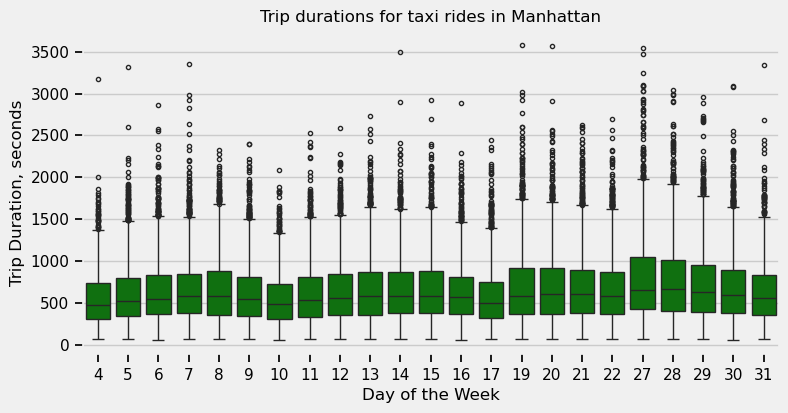

In [282]:
# A Box-plot is created to show the trip duration for each day in the month (day along x-axis, duration along y-axis)
plt.figure(figsize=(8, 4))

ax = sns.boxplot(
    x=train["day"],
    y=train["duration"],
    fliersize= 3,
    color='green'
)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Trip Duration, seconds')
ax.set_title("Trip durations for taxi rides in Manhattan");

plt.show()

## Question 3b
Add the following features to `train`, `val` and `test`. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm). Hint: np.digitize()

Because we have to do this for `train`, `val` and `test`, create a function called `add_features`.

In [284]:
def add_features(df):
    """Augment a dataframe df with additional features."""
    df_temp = df.copy()
    
    # Built-in date time functions (.hour, .dayofweek, .dayofweek) are used to generate the date-based features
    df_temp.loc[:, 'hour'] = df['pickup_datetime'].dt.hour
    df_temp.loc[:, 'day'] = df['pickup_datetime'].dt.dayofweek
    df_temp.loc[:, 'weekend'] = df['pickup_datetime'].dt.dayofweek > 4
    df_temp.loc[:, 'period'] = np.digitize(df['pickup_datetime'].dt.hour, np.array([0,6,18]))
    
    return df_temp

# Add features to train , val and test
train = add_features(train)
val = add_features(val)
test = add_features(test)

# View train DataFrame
train.head()

pickup_datetime          dropoff_datetime  passengers  \
9441  2016-01-09 14:09:26-05:00 2016-01-09 14:12:08-05:00         1.0   
86543 2016-01-13 14:55:26-05:00 2016-01-13 15:01:17-05:00         1.0   
98916 2016-01-10 17:28:29-05:00 2016-01-10 17:38:47-05:00         4.0   
3789  2016-01-13 07:44:21-05:00 2016-01-13 07:48:40-05:00         2.0   
10856 2016-01-28 21:52:03-05:00 2016-01-28 21:58:37-05:00         3.0   

       distance  pickup_lat  pickup_lon  dropoff_lat  dropoff_lon  \
9441       0.43   40.780029  -73.985023    40.781960   -73.979424   
86543      1.30   40.755695  -73.998299    40.741203   -74.002075   
98916      1.49   40.731350  -73.982407    40.730911   -74.004280   
3789       0.50   40.817715  -73.942093    40.812038   -73.947556   
10856      1.16   40.748501  -73.984848    40.741951   -73.980843   

      payment_method surcharge  ... fare   tip  \
9441               2       0.3  ...  4.0   0.0   
86543              1       0.3  ...  6.5  0.99   
98916              1       0.3  ...  8.5  2.32   
3789               2       0.3  ...  4.5   0.0   
10856              1       0.3  ...  6.5   1.0   

                                                geometry duration      speed  \
9441   MULTIPOINT (-73.98502 40.78003, -73.97942 40.7...    162.0   9.555556   
86543   MULTIPOINT (-73.9983 40.7557, -74.00208 40.7412)    351.0  13.333333   
98916  MULTIPOINT (-73.98241 40.73135, -74.00428 40.7...    618.0   8.679612   
3789   MULTIPOINT (-73.94209 40.81771, -73.94756 40.8...    259.0   6.949807   
10856  MULTIPOINT (-73.98485 40.7485, -73.98084 40.74...    394.0  10.598985   

             date day  hour  weekend  period  
9441   2016-01-09   5    14     True       2  
86543  2016-01-13   2    14    False       2  
98916  2016-01-10   6    17     True       2  
3789   2016-01-13   2     7    False       2  
10856  2016-01-28   3    21    False       3  

[5 rows x 21 columns]

## Question 3c
Use `sns.distplot` and `train` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours). Your plot should look like this.
<br>
<img src="images/q3c.png" alt="drawing" width="500"/>
<br> 

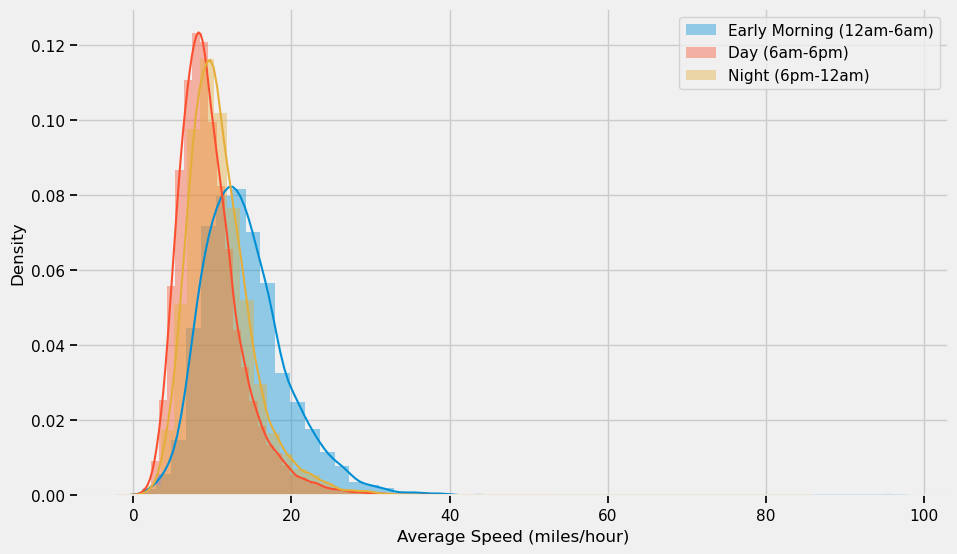

In [374]:
# A distplot is used to generate speed plots as overlays for each period (early morning, day and night)
train['duration'] /= 3600
train['avg_speed'] = train['distance'] / train['duration']

early_morning = train[train['period'] == 1]
day = train[train['period'] == 2]
night = train[train['period'] == 3]

# Plot histogram
plt.figure(figsize=(10, 6))
sns.distplot(early_morning['avg_speed'], label='Early Morning (12am-6am)')
sns.distplot(day['avg_speed'], label='Day (6am-6pm)')
sns.distplot(night['avg_speed'], label='Night (6pm-12am)')
plt.xlabel('Average Speed (miles/hour)')
plt.ylabel('Density')
plt.legend()
plt.show()

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). Before doing that, let's once again take a look at a scatterplot of trips in Manhattan.

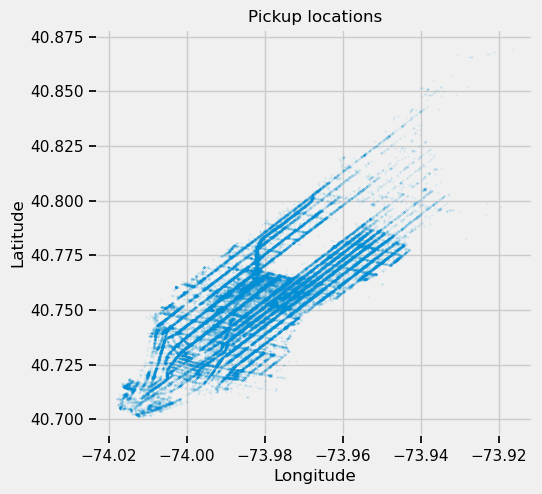

In [288]:
plt.figure(figsize=(5, 5))
plt.scatter(x = manhattan_taxi['pickup_lon'], 
            y = manhattan_taxi['pickup_lat'], s=0.1, alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup locations');

Add a `region` column to `train`, `val` and `test` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

Read the documentation of [`pd.qcut`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html), which categorizes points in a distribution into equal-frequency bins.

In [290]:
from sklearn.decomposition import PCA

First, let's calculate the first principal component (PCA1) using `'pickup_lon'` and `'pickup_lat'` from `train`.

In [292]:
pca = PCA(n_components=1)
pca.fit(train[['pickup_lon', 'pickup_lat']])

PCA(n_components=1)

In [294]:
print('Principal component 1 explains {:.2f} % of the variance in "pickup_lon" and "pickup_lat".'.format(pca.explained_variance_ratio_[0] * 100))

Principal component 1 explains 88.36 % of the variance in "pickup_lon" and "pickup_lat".


Next, we need to transform `['pickup_lon', 'pickup_lat']` into principal component 1.

In [296]:
pc1 = pca.transform(train[['pickup_lon', 'pickup_lat']])
print('Original shape: ', train[['pickup_lat', 'pickup_lon']].shape)
print('Transformed shape of PC1: ', pc1.shape)

Original shape:  (47090, 2)
Transformed shape of PC1:  (47090, 1)


As we can see, we have reduced from 2 dimensions (2 features) to 1 dimension and this one dimension (or Principal Component), explains 88% of the variance in the original two dimensions. 

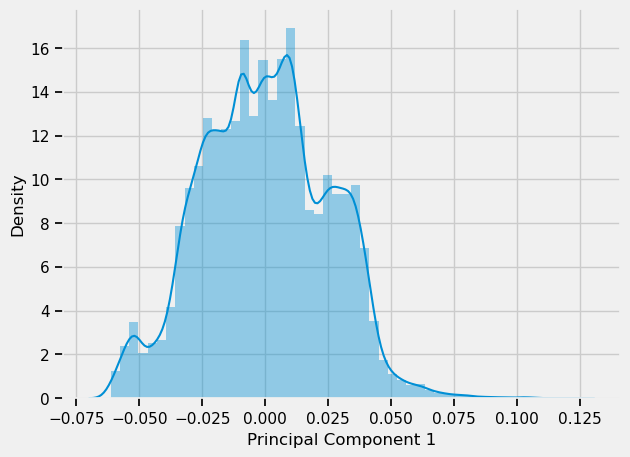

In [298]:
ax = sns.distplot(pc1)
ax.set_xlabel('Principal Component 1');

Below, you can see that our (latitude, longitude) locations have been collapsed to a single line.

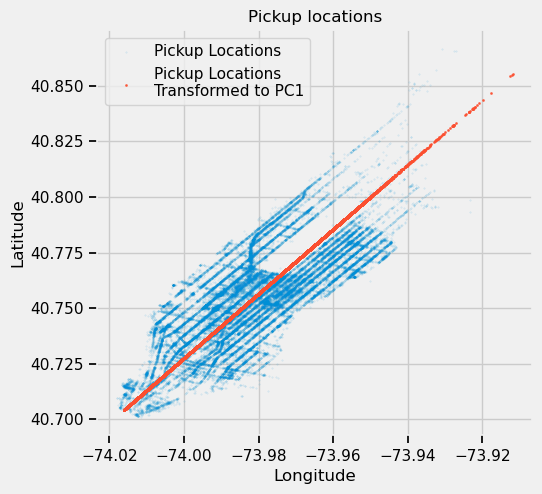

In [300]:
X_new = pca.inverse_transform(pc1)
plt.figure(figsize=(5, 5))
plt.scatter(x = train['pickup_lon'], 
            y = train['pickup_lat'], s=0.1, alpha=0.2, label='Pickup Locations')
plt.scatter(x = X_new[:, 0], y = X_new[:, 1], s=1, alpha=0.8, label='Pickup Locations\nTransformed to PC1')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup locations');

Next, we need to categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component `pc1`.

In [302]:
out, bins = pd.qcut(pc1.flatten(), 3, labels=[1, 2, 3], retbins=True)
print(out)
print(bins)

[3, 2, 1, 3, 2, ..., 2, 3, 1, 3, 1]
Length: 47090
Categories (3, int64): [1 < 2 < 3]
[-0.06143656 -0.01110363  0.01071898  0.12224273]


Let's see what these regions look like.

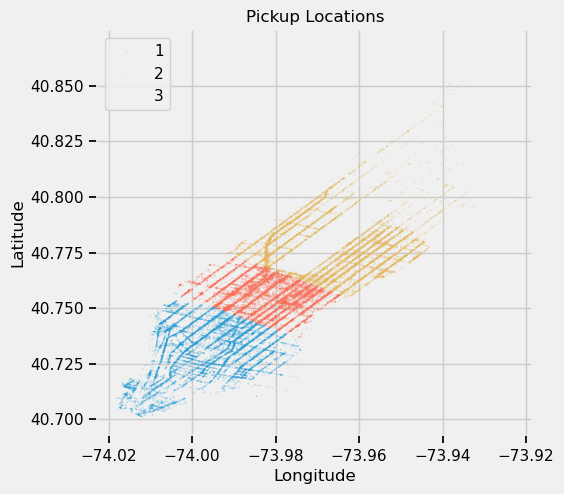

In [386]:
# Assuming pc1 is defined and corresponds to your PCA transformation
X_new = pca.inverse_transform(pc1)  # Check if pc1 is correctly defined and has the right shape

# Create a scatter plot for pickup locations
plt.figure(figsize=(5, 5))
sns.scatterplot(x=train['pickup_lon'], 
                y=train['pickup_lat'], 
                hue=out,  # Ensure 'out' is defined
                s=1, 
                alpha=0.2)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup Locations')
plt.show()

Next, let's create a function `add_region` so we can reuse this workflow.

In [310]:
pca = PCA(n_components=1)
pca.fit(train[['pickup_lon', 'pickup_lat']])
pc1 = pca.transform(train[['pickup_lon', 'pickup_lat']])
out, bins = pd.qcut(pc1.flatten(), 3, labels=[1, 2, 3], retbins=True)

def add_region(df, pca, bins):
    """Add a "region" column to df_temp."""
    df_temp = df.copy()
    
    # Write your code here
    pc1 = pca.transform(df_temp[['pickup_lon', 'pickup_lat']])
    df_temp['region'] = pd.cut(pc1.flatten(), 
                               [-np.inf, bins[1], bins[2], np.inf], 
                               labels=[1, 2, 3])
    
    return df_temp

# Now let's add 'region' to train, val and test
train = add_region(train, pca, bins)
val = add_region(val, pca, bins)
test = add_region(test, pca, bins)

Below, we compare the `region`'s calculated from the training dataset and applied to the validation dataset.

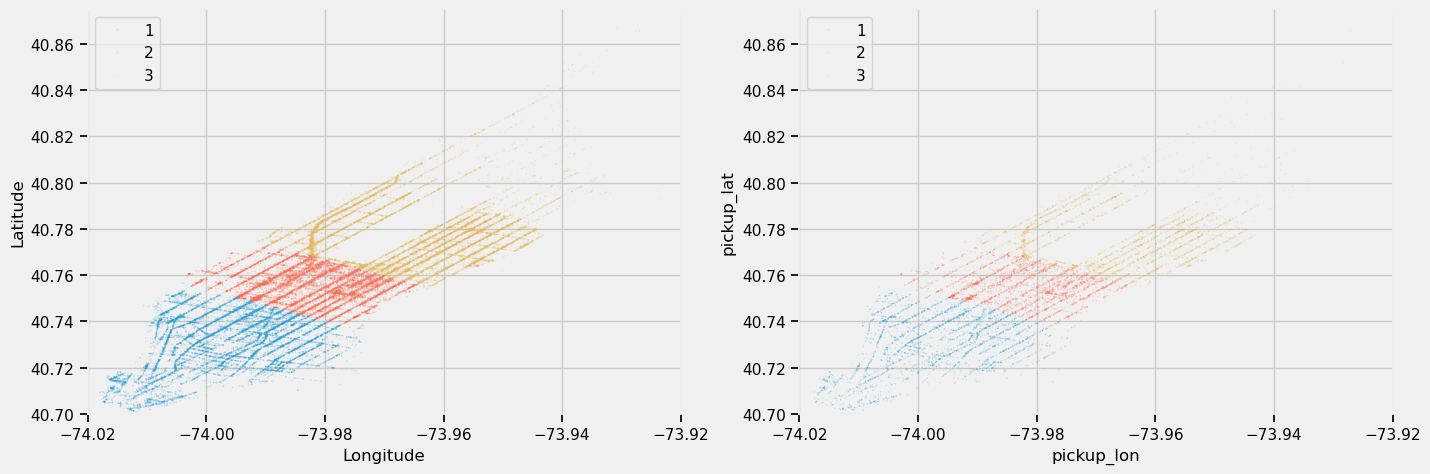

In [392]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(data=train, x='pickup_lon', y='pickup_lat', hue='region',
                s=1, alpha=0.2, ax=ax1)
ax1.set_xlim([-74.02, -73.92])
ax1.set_ylim([40.7, 40.875])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend()

sns.scatterplot(data=val, x='pickup_lon', y='pickup_lat', hue='region',
                s=1, alpha=0.2, ax=ax2)
ax2.set_xlim([-74.02, -73.92])
ax2.set_ylim([40.7, 40.875])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax2.legend();

Pay attention to this important step in the workflow. You'll notice that `pc1` and the `region` bin limits where computed exclusively from the training dataset and then applied to the validation and test datasets. This is important for ensure no data leakage occurs. `#data-leakage`

## Question 3d
Use `sns.distplot` to create an overlaid histogram comparing the distribution of speeds for morning taxi rides (12am-6am) in the three different regions defined above using `train`. Ponder if there is an association between region and average speed during the night.

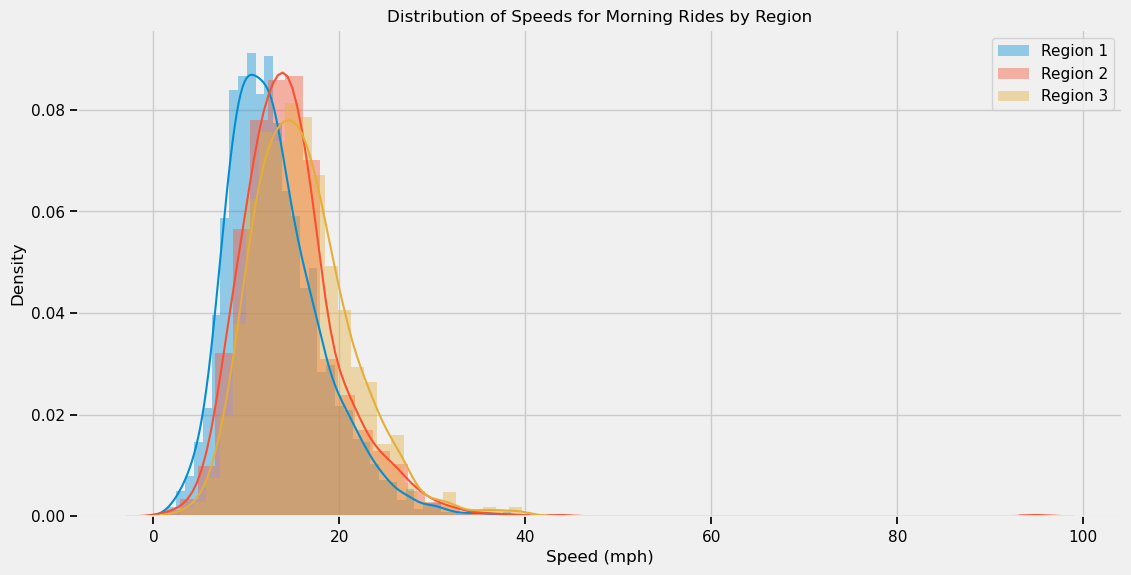

In [378]:
# A distplot is used to generate an overlay histogram for morning speeds in each region (lower, mid and upper-Manhattan)
morning_region1 = train[(train['period'] == 1) & (train['region'] == 1)]
morning_region2 = train[(train['period'] == 1) & (train['region'] == 2)]
morning_region3 = train[(train['period'] == 1) & (train['region'] == 3)]

plt.figure(figsize=(12, 6))
sns.distplot(morning_region1['speed'], label='Region 1')
sns.distplot(morning_region2['speed'], label='Region 2')
sns.distplot(morning_region3['speed'], label='Region 3')
plt.title('Distribution of Speeds for Morning Rides by Region')
plt.xlabel('Speed (mph)')
plt.ylabel('Density')
plt.legend()
plt.show()

Lastly, let's create a feature set that includes our features of interest. Quantitative features are converted to standard units using `StandardScaler`, while categorical features are converted to dummy variables using `pd.get_dummies`. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is **NOT** included because it was computed from the `duration` and the `distance`. This would be an example of a type of data leakage called target leakage. This occurs when information about the training target leaks into the features.

In [316]:
from sklearn.preprocessing import StandardScaler

# Define numerical features to use for modelling
num_features = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 
                'distance']

# Define categorical features to use for modelling
cat_features = ['hour', 'day', 'region']

# Fit scaler (basically get the mean and stdev) for the training data
scaler = StandardScaler()
scaler.fit(train[num_features])

def create_features(df):
    """Create a feature set from taxi ride dataframe df."""
    scaled = df[num_features].copy()
    
    # Convert numeric features to standard units
    scaled.iloc[:, :] = scaler.transform(scaled) 
    
    # Convert categorical features using dummy encoding
    categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in cat_features]
    
    return pd.concat([scaled] + categoricals, axis=1)

# Let's test our function
create_features(train).head()

pickup_lon  pickup_lat  dropoff_lon  dropoff_lat  distance  hour_1  \
9441    -0.230091    1.193917     0.048437     1.094580 -1.011939   False   
86543   -1.054552    0.050581    -1.264620    -0.621418 -0.395268   False   
98916   -0.067568   -1.093293    -1.392432    -1.054755 -0.260593   False   
3789     2.436141    2.964572     1.895739     2.361020 -0.962322   False   
10856   -0.219193   -0.287455    -0.033823    -0.589938 -0.494503   False   

       hour_2  hour_3  hour_4  hour_5  ...  hour_22  hour_23  day_1  day_2  \
9441    False   False   False   False  ...    False    False  False  False   
86543   False   False   False   False  ...    False    False  False   True   
98916   False   False   False   False  ...    False    False  False  False   
3789    False   False   False   False  ...    False    False  False   True   
10856   False   False   False   False  ...    False    False  False  False   

       day_3  day_4  day_5  day_6  region_2  region_3  
9441   False  False   True  False     False      True  
86543  False  False  False  False      True     False  
98916  False  False  False   True     False     False  
3789   False  False  False  False     False      True  
10856   True  False  False  False      True     False  

[5 rows x 36 columns]

# 4. Model Selection
In this part, you will select a regression model to predict the duration of a taxi ride.

## Question 4a
Assign `constant_rmse` to the root mean squared error on the validation set for a constant model that always predicts the mean duration of all training set taxi rides. Its always benefitial to have a simple (naive) baseline to compare our more sophisticated models too.

In [318]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

# The constant_rmse is found by apply rmse function to mean training duration minus val duration
constant_rmse = rmse(np.mean(train['duration'])-val['duration'])

# Print score
print('Constant model validation RMSE: {} seconds'.format(constant_rmse))

Constant model validation RMSE: 406.75430187653905 seconds


## Question 4b
Assign `simple_rmse` to the root mean squared error on the validation set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

Simple linear regression means that there is only one feature. Multiple linear regression means that there is more than one feature. In either case, you can use the `LinearRegression` model from `sklearn` to fit the parameters to data.

In [320]:
from sklearn.linear_model import LinearRegression

#Two functions are created for a data pipeline: one to select columns from dataframe, and another to process the data
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for a guided model."""
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'duration', 
                          'distance')
    
    # Return predictors and response variables separately
    X = data.drop(['duration'], axis = 1)
    y = data.loc[:, 'duration']
    
    return X, y

X_val, y_val = process_data(val)
X_train, y_train = process_data(train)

# Initialize model
linear_model_distance = LinearRegression(fit_intercept=True)

# Fit model using train data. 
linear_model_distance.fit(X_train, y_train)

# Generate prediction using val data
y_predicted_val_duration = linear_model_distance.predict(X_val)

# RMSE is found between y-val and predicted results
simple_rmse = rmse(y_val - y_predicted_val_duration)

# Print score
print('Simple linear regression model validation RMSE: {} seconds'.format(simple_rmse))

Simple linear regression model validation RMSE: 278.49968409846326 seconds


## Question 4c
Assign `linear_rmse` to the root mean squared error on the validation set for a linear regression model fitted to the training set without regularization, using the feature set defined by the `create_features` function from Part 3.

In [322]:
# The process_data function is created to create a pipline for the data
def process_data(data):
    """Process the data for a guided model."""
    
    # Return predictors and response variables separately.
    #X features are calculated using the create_features function.
    
    X = create_features(data)
    y = data[['duration']]
    
    return X, y

X_train, y_train = process_data(train)
X_val, y_val = process_data(val)

# Initialize model
linear_model_train_feature_distance = LinearRegression(fit_intercept=True)

# Fit model to training data. Prediction is found on val
linear_model_train_feature_distance.fit(X_train, y_train)
y_predicted_feature_duration = linear_model_train_feature_distance.predict(X_val)

# Linear RMSE is calculated using y_val and y_predicted
linear_rmse = float(rmse(y_predicted_feature_duration-y_val))

# Print score
print('Multiple linear regression model validation RMSE: {} seconds'.format(linear_rmse))

Multiple linear regression model validation RMSE: 257.8884859256028 seconds


## Question 4d
For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  Assign `period_rmse` to the root mean squared error on the validation set for a model that first chooses linear regression parameters based on the observed `period` of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `create_features` function for features.

In [324]:
model = LinearRegression(fit_intercept=True)
val_errors = []

for period in np.unique(train['period']):
    
    # Filter to period
    period_train = train[train['period'] == period]
    period_val = val[val['period'] == period]
    
    # Fit model
    #The process_data function is reused from 4c, to use the create_features function again
    period_x_train, period_y_train = process_data(period_train)
    period_x_val, period_y_val = process_data(period_val)
    
    
    # The model is fit on the train data, and predictions are made on val data.
    model.fit(period_x_train, period_y_train)
    period_y_predicted = model.predict(period_x_val)
    
    # Compute period errors
    period_errors = period_y_val - period_y_predicted

    # Collect errors
    val_errors.extend(period_errors['duration'])

# Compute val score
period_rmse = rmse(np.array(val_errors))

# Print score
print('Period linear regression model validation RMSE: {} seconds'.format(period_rmse))

Period linear regression model validation RMSE: 247.8411421207052 seconds


This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

## Question 4e
Instead of predicting duration directly, an alternative is to predict the average speed of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

Assign `speed_rmse` to the root mean squared error in the duration predicted by a model that first predicts speed as a linear combination of features from the `create_features` function, fitted on the training set, then calculates duration from the predicted speed and observed distance for the validation set.

Hint: Speed is in miles per hour, but duration is measured in seconds. You'll need the fact that there are 60 * 60 = 3,600 seconds in an hour.

In [326]:
# The process_data function is created to create a pipline for the data
def process_data(data):
    """Process the data for a guided model."""
    

    # Return predictors and response variables separately.
    # X features are calculated using the create_features function.
    # y now becomes the speed values
    
    X = create_features(data)
    y = data[['speed']]
    
    return X, y

X_train, y_train = process_data(train)
X_val, y_val = process_data(val)

# Initialize model
linear_model_speed = LinearRegression(fit_intercept=True)

# Fit model on train data. y is predicted on the validation data.
linear_model_speed.fit(X_train, y_train)
y_predicted = linear_model_speed.predict(X_val)

# Duration is calculated from distance and speed
y_predicted_duration = np.array(val[['distance']]) / y_predicted * 3600
y_val_duration = np.array(val[['distance']]) / y_val * 3600

speed_rmse = float(rmse(y_predicted_duration - y_val_duration))

# Print score
print('Speed multiple linear regression model validation RMSE: {} seconds'.format(speed_rmse))

Speed multiple linear regression model validation RMSE: 245.768732410258 seconds


At this point, think about why predicting speed leads to a more accurate regression model than predicting duration directly. Consider the figure below.

Text(0.5, 0, 'Speed, mph')

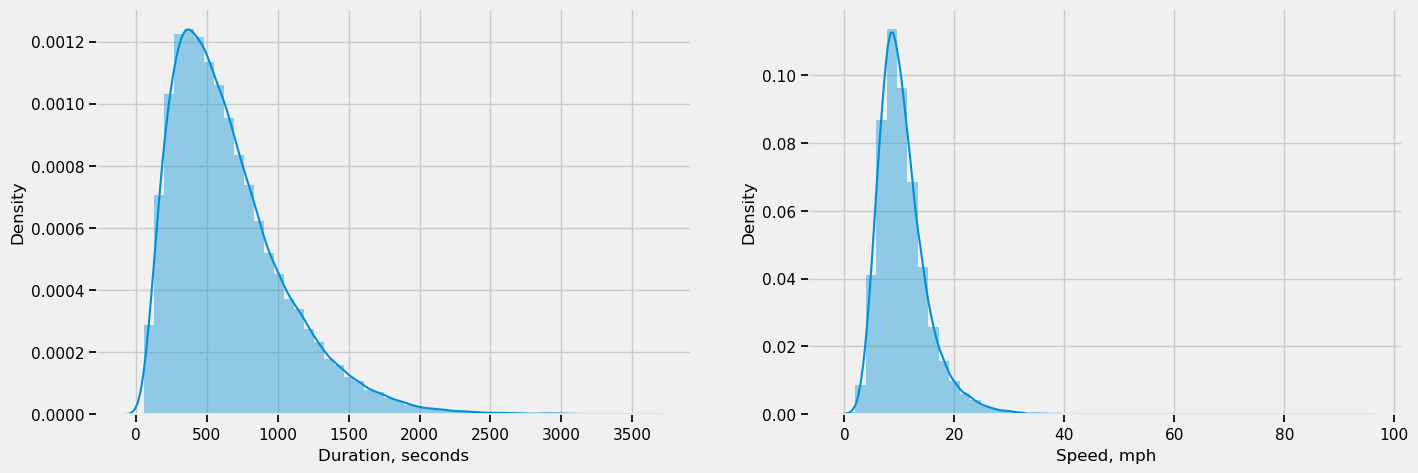

In [328]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(train['duration'], ax=ax1)
ax1.set_xlabel('Duration, seconds')

sns.distplot(train['speed'], ax=ax2)
ax2.set_xlabel('Speed, mph')

The `duration` has a large right-skew and a larger dynamics range, which can create challenges. `speed` is much closed to a symmetric distribution, which is the likely explanation for this improved performance. Another option to try would be to use a `log` transformation on `duration`.

Text(0.5, 0, 'log Duration, seconds')

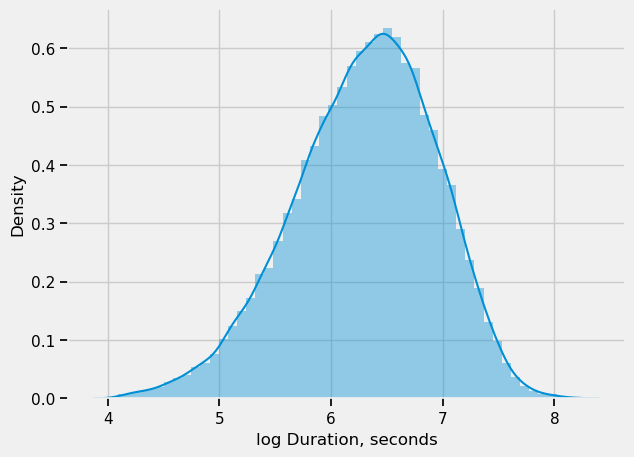

In [330]:
ax= sns.distplot(np.log(train['duration']))
ax.set_xlabel('log Duration, seconds')

Next, let's select the best model based on its validation score.

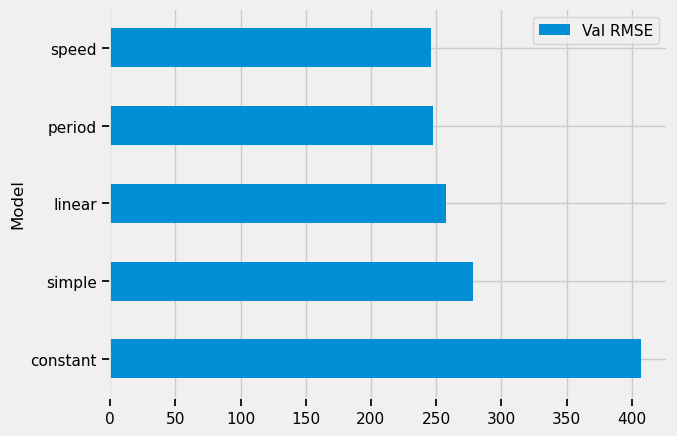

In [332]:
models = ['constant', 'simple', 'linear', 'period', 'speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Val RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

Based on the results presented above, we select the `speed` model, which has the lowest RMSE on the validation dataset.

## Question 4f
The last step is to unlock out test dataset and compute the RMSE for the `speed` model as our final evaluation of the model's generalization error.

In [334]:
# The process_data function is reused from 4e on test data
X_test, y_test = process_data(test)

# A prediction is generated using the model from 4e
y_test_predicted = linear_model_speed.predict(X_test)

# Duration is calculated from distance and speed
y_predicted_duration = np.array(test[['distance']]) / y_test_predicted * 3600
y_test = np.array(test[['distance']]) / y_test * 3600

# The RMSE function is applied.
speed_rmse_test = float(rmse(y_predicted_duration - y_test))

# Print score
print('Speed multiple linear regression model test RMSE: {} seconds'.format(speed_rmse_test))

Speed multiple linear regression model test RMSE: 245.4840718103312 seconds
